In [2]:
import torch
import pickle
import numpy as np
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, GINConv, GATConv
from torch_geometric.loader import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Load data splits
# dataset = 'fer2013'
dataset = 'ck'
train_data_path = dataset + '_data/train_data_70_20_10.pkl'
val_data_path = dataset + '_data/val_data_70_20_10.pkl'
test_data_path = dataset + '_data/test_data_70_20_10.pkl'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

# Add batch attribute to each data object
for data in train_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in val_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in test_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


# Models

In [4]:
from torch_geometric.nn import BatchNorm
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GraphConv

class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device='cpu'):
        super(GIN, self).__init__()
        self.device = device
        nn1 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden_dim)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden_dim)
        
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        return global_mean_pool(x, batch)
    
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device='cpu'):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.lin = torch.nn.Linear(hidden_dim * 4, output_dim)
        self.device = device

    def forward(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        return global_mean_pool(x, batch)
    
class GCNSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device='cpu'):
        super(GCNSAGE, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return global_mean_pool(x, batch)

# Graph Conv
class GConv(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device='cpu'):
        super(GConv, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return global_mean_pool(x, batch)
    
class GINBNorm(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device='cpu'):
        super(GINBNorm, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden_dim)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden_dim)
        
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, data):
        data = data.to(self.device)
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        return global_mean_pool(x, batch)

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

def evaluate_xgb(model, train_loader, test_loader, device='cpu'):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for idx, data in enumerate(train_loader):
        data = data.to(device)
        out = model.get_embeddings(data).cpu().detach().numpy()
        X_train.extend(out.tolist())
        y_train.extend(data.y.cpu().detach().numpy().tolist())
    
    for idx, data in enumerate(test_loader):
        data = data.to(device)
        out = model.get_embeddings(data).cpu().detach().numpy()
        X_test.extend(out.tolist())
        y_test.extend(data.y.cpu().detach().numpy().tolist())
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    #Creating an XGBoost classifier
    xgb_model = xgb.XGBClassifier()
    
    #Training the model on the training data
    xgb_model.fit(X_train, y_train)
    
    #Making predictions on the test set
    predictions = xgb_model.predict(X_test)
    
    #Calculating accuracy
    test_accuracy = accuracy_score(y_test, predictions)
    train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
    
    return test_accuracy, train_accuracy
    #print("\nClassification Report:")
    #print(classification_report(y_test, predictions, target_names=label_mapping))

In [6]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    model.to(device)
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return total_loss / len(train_loader), correct / total

def evaluate(model, device, loader, criterion):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return correct / total, val_loss / len(loader), all_labels, all_preds


In [24]:
from sklearn.model_selection import ShuffleSplit


def run_cross_validation(model_class,
                         all_data, 
                         device, 
                         n_epochs=501,
                         batch_size=32,
                         n_splits=20, 
                         test_size=0.25,
                         ):
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    all_train_losses = []
    all_train_accuracies = []
    all_xgb_test_accuracies = []
    all_xgb_train_accuracies = []
    all_test_losses = []
    all_test_accuracies = []
    print("Starting pipeline...")
    for i, (train_index, test_index) in enumerate(splitter.split(all_data)):
        model = model_class(input_dim=3, hidden_dim=64, output_dim=output_dim, device=device)
        train_losses = []
        train_accuracies = []
        xgb_test_accuracies = []
        xgb_train_accuracies = []
        test_losses = []
        test_accuracies = []
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_data = [all_data[idx] for idx in train_index]
        test_data = [all_data[idx] for idx in test_index]
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        # Initialize model, optimizer, and criterion

        # Calculate class weights
        label_counts = np.bincount([data.y.item() for data in train_data])
        class_weights = 1.0 / label_counts
        class_weights = class_weights / class_weights.sum()
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
        
        for epoch in range(n_epochs):
            train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc) 
            xgb_test_acc, xgb_train_acc = evaluate_xgb(model, train_loader, test_loader)
            xgb_train_accuracies.append(xgb_train_acc)
            xgb_test_accuracies.append(xgb_test_acc)
            test_acc, test_loss, test_labels, test_preds = evaluate(
                model, 
                device, 
                test_loader, 
                criterion
            )
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
        
        print(f'Split: {i+1}/{n_splits}, Test Loss: {test_loss:.4f}, Test Acc: {int(100 * test_acc):02d}%')
        print(f'XGB Accuracy for Last epoch: {xgb_test_accuracies[-1]:.4f}')
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_xgb_train_accuracies.append(xgb_train_accuracies)
        all_xgb_test_accuracies.append(xgb_test_accuracies)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    return all_test_losses, all_test_accuracies, all_train_losses, all_train_accuracies, all_xgb_train_accuracies, all_xgb_test_accuracies

In [28]:
label_mapping = ['neutral', 'happiness', 'sadness', 'surprise', 'fear',
                 'disgust', 'anger', 'contempt']
output_dim = len(np.unique([data.y.item() for data in train_data]))
models = {
    "GIN": (GIN, 'mps'),
    "GAT": (GAT, 'cpu'),
    "GCNSAGE": (GCNSAGE, 'mps'),
    "GConv": (GConv, 'mps'),
    "GINBNorm": (GINBNorm, 'mps')
}

all_data = train_data + val_data + test_data
output_dim = len(np.unique([data.y.item() for data in train_data]))
results_dict = {}
for model_name, (model, device) in models.items():
    test_losses, test_accuracies, all_train_losses, all_train_accuracies, all_xgb_train_accuracies, all_xgb_test_accuracies = run_cross_validation(
        model,
        all_data, 
        device, 
        n_epochs=250,
        n_splits=10
    )
    results_dict[model_name] = {
        'all_test_losses': test_losses,
        'all_test_accuracies': test_accuracies,
        'all_train_losses': all_train_losses,
        'all_train_accuracies': all_train_accuracies,
        'all_xgb_train_accuracies': all_xgb_train_accuracies,
        'all_xgb_test_accuracies': all_xgb_test_accuracies,
    }

Starting pipeline...
Split: 1/10, Test Loss: 0.8303, Test Acc: 64%
XGB Accuracy for Last epoch: 0.6095
Split: 2/10, Test Loss: 0.9999, Test Acc: 61%
XGB Accuracy for Last epoch: 0.7143
Split: 3/10, Test Loss: 0.8839, Test Acc: 62%
XGB Accuracy for Last epoch: 0.7143
Split: 4/10, Test Loss: 1.0274, Test Acc: 66%
XGB Accuracy for Last epoch: 0.7429
Split: 5/10, Test Loss: 0.8897, Test Acc: 73%
XGB Accuracy for Last epoch: 0.7048
Split: 6/10, Test Loss: 0.8405, Test Acc: 65%
XGB Accuracy for Last epoch: 0.7143
Split: 7/10, Test Loss: 0.9343, Test Acc: 60%
XGB Accuracy for Last epoch: 0.6762
Split: 8/10, Test Loss: 0.7454, Test Acc: 72%
XGB Accuracy for Last epoch: 0.6286
Split: 9/10, Test Loss: 0.6920, Test Acc: 77%
XGB Accuracy for Last epoch: 0.7524
Split: 10/10, Test Loss: 0.7606, Test Acc: 71%
XGB Accuracy for Last epoch: 0.7714
Starting pipeline...
Split: 1/10, Test Loss: 1.1884, Test Acc: 44%
XGB Accuracy for Last epoch: 0.5619
Split: 2/10, Test Loss: 1.2429, Test Acc: 52%
XGB Accur

In [32]:
results_dict['GIN'].keys()

dict_keys(['all_test_losses', 'all_test_accuracies', 'all_train_losses', 'all_train_accuracies', 'all_xgb_train_accuracies', 'all_xgb_test_accuracies'])

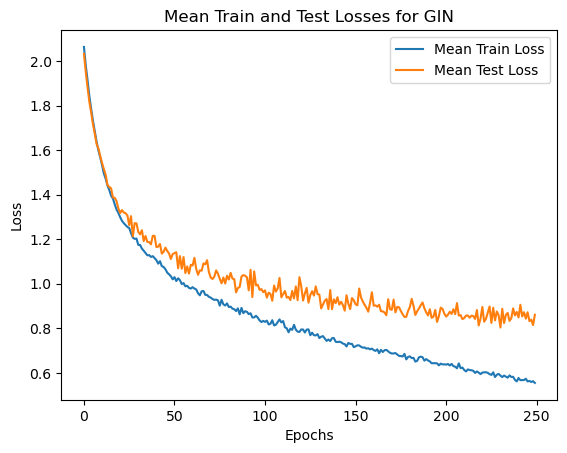

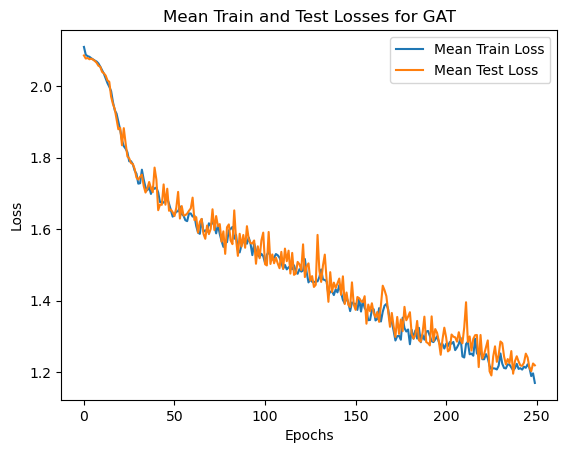

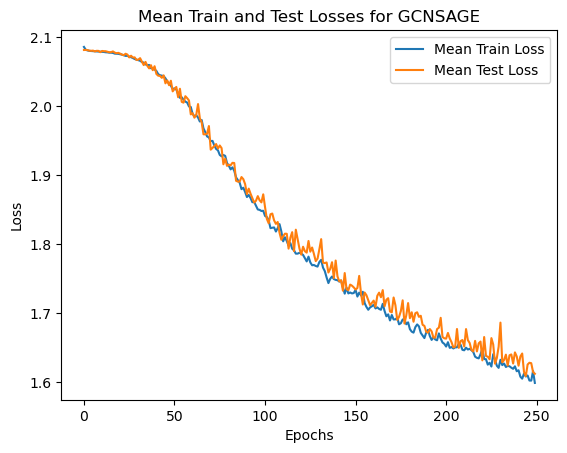

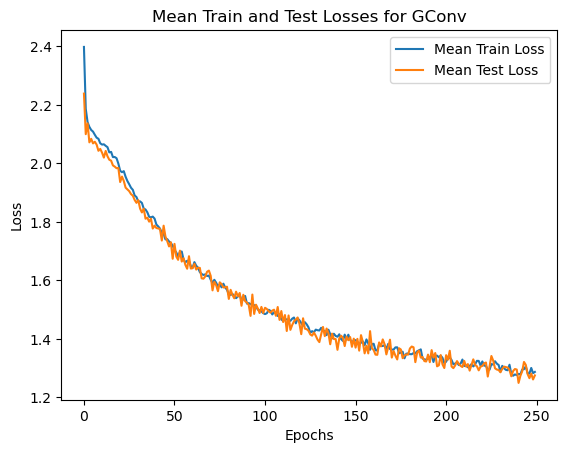

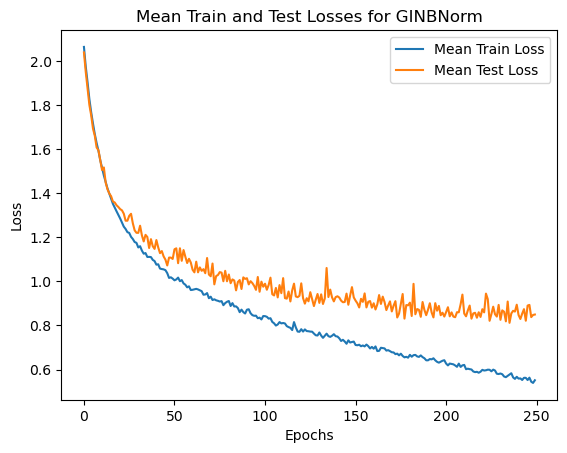

In [43]:
import os

for model_name in results_dict.keys():
    all_test_losses = results_dict[model_name]['all_test_losses']
    all_test_accuracies = results_dict[model_name]['all_test_accuracies']
    all_train_losses = results_dict[model_name]['all_train_losses']
    all_train_accuracies = results_dict[model_name]['all_train_accuracies']
    all_xgb_train_accuracies = results_dict[model_name]['all_xgb_train_accuracies']
    all_xgb_test_accuracies = results_dict[model_name]['all_xgb_test_accuracies']
    # Plot train and test losses
    np_train_losses = np.array(all_train_losses)
    np_test_losses = np.array(all_test_losses)
    mean_train_losses = np.mean(np_train_losses, axis=0)
    mean_test_losses = np.mean(np_test_losses, axis=0)
    # Plot losses by epoch
    plt.plot(mean_train_losses, label='Mean Train Loss')
    plt.plot(mean_test_losses, label='Mean Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Mean Train and Test Losses for {model_name}')
    plt.legend()
    # Save plot in results directory
    if not os.path.exists(f'results/{model_name}'):
        os.makedirs(f'results/{model_name}')
    plt.savefig(f'results/{model_name}/losses.png')
    plt.show()
    

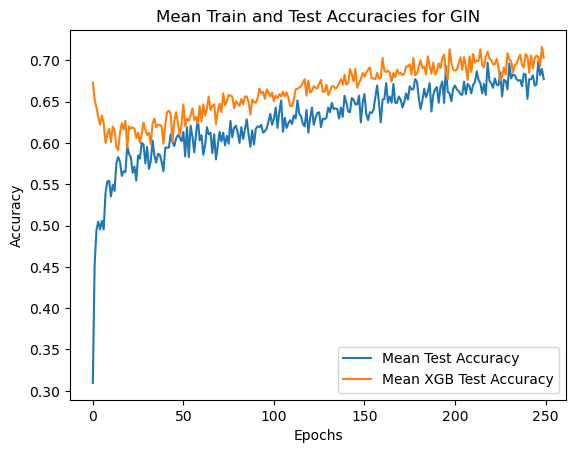

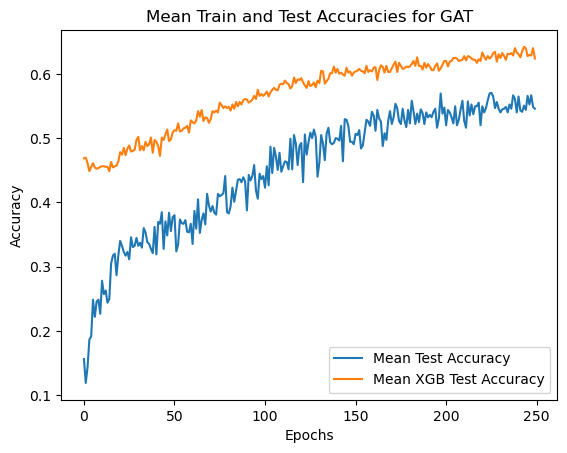

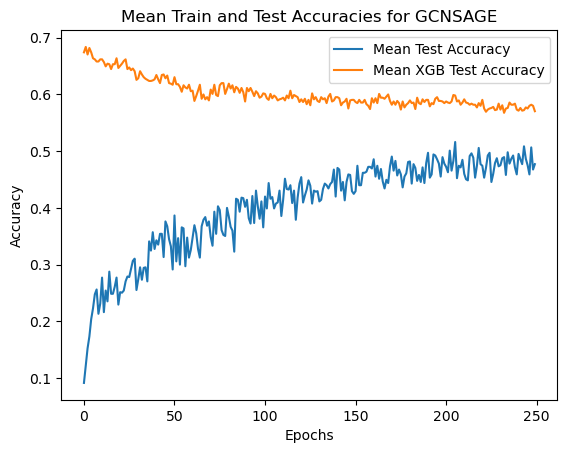

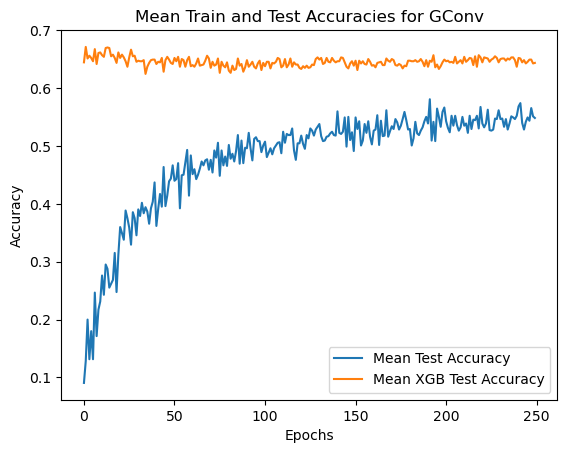

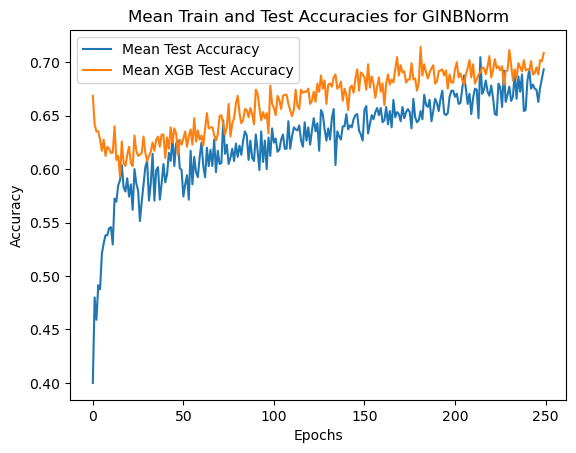

In [44]:
# Plot train , test and xgb test accuracy

for model_name in results_dict.keys():
    all_train_accuracies = results_dict[model_name]['all_train_accuracies']
    all_test_accuracies = results_dict[model_name]['all_test_accuracies']
    all_xgb_train_accuracies = results_dict[model_name]['all_xgb_train_accuracies']
    all_xgb_test_accuracies = results_dict[model_name]['all_xgb_test_accuracies']
    
    np_train_accuracies = np.array(all_train_accuracies)
    np_test_accuracies = np.array(all_test_accuracies)
    np_xgb_train_accuracies = np.array(all_xgb_train_accuracies)
    np_xgb_test_accuracies = np.array(all_xgb_test_accuracies)
    
    mean_train_accuracies = np.mean(np_train_accuracies, axis=0)
    mean_test_accuracies = np.mean(np_test_accuracies, axis=0)
    mean_xgb_train_accuracies = np.mean(np_xgb_train_accuracies, axis=0)
    mean_xgb_test_accuracies = np.mean(np_xgb_test_accuracies, axis=0)
    
    # Plot accuracies by epoch
    # plt.plot(mean_train_accuracies, label='Mean Train Accuracy')
    plt.plot(mean_test_accuracies, label='Mean Test Accuracy')
    plt.plot(mean_xgb_test_accuracies, label='Mean XGB Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Mean Train and Test Accuracies for {model_name}')
    plt.legend()
    # Save plot in results directory
    if not os.path.exists(f'results/{model_name}'):
        os.makedirs(f'results/{model_name}')
    plt.savefig(f'results/{model_name}/accuracies.png')
    plt.show()


In [46]:
# Save results dict
import json

with open('results.json', 'w') as f:
    f.write(json.dumps(results_dict))